In [1]:
import numpy as np
import matplotlib.pyplot as plt

# Generate Some Categorical Data

In [38]:
samples = 100
X1 = np.concatenate((np.random.normal(0, 1, samples), np.random.normal(5, 1, samples)))
X2 = np.concatenate((np.random.normal(0, 1, samples), np.random.normal(5, 1, samples)))
S = np.concatenate((np.zeros(samples), np.zeros(samples)))

In [39]:
X1 = np.concatenate((X1, np.random.normal(5, 1, samples)))
X2 = np.concatenate((X2, np.random.normal(0, 1, samples)))
S = np.concatenate((S, np.ones(samples)))

In [40]:
X1 = np.concatenate((X1, np.random.normal(0, 1, samples)))
X2 = np.concatenate((X2, np.random.normal(5, 1, samples)))
S = np.concatenate((S, np.ones(samples)))

In [41]:
X = np.vstack((X1, X2)).T

In [42]:
marks = S.tolist()

In [43]:
marks[marks == 0] = 'x'
marks[marks == 1] = '.'

Text(0, 0.5, 'X2')

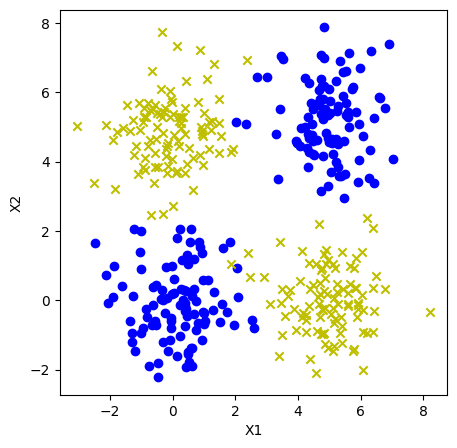

In [44]:
fig = plt.figure(figsize=(5, 5))
plt.scatter(X1[S==0], X2[S==0], c='b', marker='o')
plt.scatter(X1[S==1], X2[S==1], c='y', marker='x')
plt.xlabel('X1')
plt.ylabel('X2')

# Decision Trees (Classification)

Decision Trees are built with binary trees where you traverse through internal nodes, answering questions on each, to reach leaves which either classify your data. This is a highly nonlinear process and classifier. 

A decision tree is built by splitting the data at various boundaries. Each possible threshold for the splits is optimized based on how much information is gained by using the threshold, that is, the entropy after the split has to be minimized to have an optimized decision tree.

A number of measures are used for this information gain optimization. Most popular are

- Gini Impurity $E = 1 - \sum p^2$
- Information / Shannon Entropy $E = -\sum p \log{p}$
- For regression trees, MSE is typically used.

Te node at the top is called the root node, it is split into internal nodes through branches. Each of these nodes is a question, if the answer is true, we go to the left branch, if false, we go to the right branch. Once we've questioned enough to establish the class of a datapoint with certainty, the last node is called a leaf. 

Two important hyperparameters in decision trees are:

- Max Depth: This defines how many levels are we willing to go at max in the tree.
- Min Samples for Split: The minimum samples / number of datapoints which must be on a leaf, to be able to turn that leaf into an internal node and split it further.

# Implementation

A decision tree has many nodes, so having a class for nodes makes life much easier. Each node needs to have the attributes left and right to link it with its left and right node. Each node also needs the attribute of value in case it's a leaf node, and attributes for feature and threshold to define the feature which splits this node and the threshold for splitting. Attributes for the number of samples on the node are also helpful.

In [45]:
class Node():
    def __init__(self, left=None, right=None, value=None, feature=None, threshold=None, n_samples=None, is_leaf=None):
        self.left = left
        self.right = right
        self.value = value
        self.feature = feature
        self.threshold = threshold
        self.num_samples = n_samples
        self.is_leaf = is_leaf

In [64]:
class DecisionTreeClassifier():
    def __init__(self, max_depth=None, min_samples_for_split=None):
        self.max_depth = max_depth
        self.min_samples = min_samples_for_split
        self.root = None
        self.depth = None

    def shannon_entropy(self, y):
        _, counts = np.unique(y, return_counts=True)
        probabilities = counts / counts.sum()
        return -np.sum(probabilities * np.log2(probabilities))

    def leaf_value(self, y):
        unique_classes, counts = np.unique(y, return_counts=True)
        return unique_classes[np.argmax(counts)]

    def create_split(self, X, y, feature_idx, threshold):

        X_left = X[X[:, feature_idx] <= threshold]
        X_right = X[X[:, feature_idx] > threshold]
        y_left = y[X[:, feature_idx] <= threshold]
        y_right = y[X[:, feature_idx] > threshold]

        return X_left, y_left, X_right, y_right
    
    def best_split(self, X, y):

        best_feature, best_threshold, best_gain = None, None, -np.inf
        current_entropy = self.shannon_entropy(y)

        for feature_idx in range(X.shape[1]):

            thresholds = np.unique(X[:, feature_idx])

            for threshold in thresholds:
                X_left, y_left, X_right, y_right = self.create_split(X, y, feature_idx, threshold)
                if len(y_left) < self.min_samples or len(y_right) < self.min_samples:
                    continue

                left_impurity = self.shannon_entropy(y_left)
                right_impurity = self.shannon_entropy(y_right)
                weighted_impurity = (len(y_left) * left_impurity + len(y_right) * right_impurity) / X.shape[0]

                impurity_gain = current_entropy - weighted_impurity
                if impurity_gain > best_gain:
                    best_feature = feature_idx
                    best_threshold = threshold
                    best_gain = impurity_gain

        return best_feature, best_threshold
    
    def build_tree(self, X, y, depth=0):

        self.depth = depth
        node_value = self.leaf_value(y)
        node = Node(value=node_value, is_leaf=True, n_samples=X.shape[0])

        if (self.max_depth is None or depth < self.max_depth) and len(y) >= self.min_samples and len(np.unique(y)) > 1:
            best_feature, best_threshold = self.best_split(X, y)
            if best_feature is not None:
                X_left, y_left, X_right, y_right = self.create_split(X, y, best_feature, best_threshold)
                left_node = self.build_tree(X_left, y_left, depth + 1)
                right_node = self.build_tree(X_right, y_right, depth + 1)

                node.feature = best_feature
                node.threshold = best_threshold
                node.left = left_node
                node.right = right_node
                node.is_leaf = False

        return node
      
    def traverse_tree(self, x, node):
        if node.is_leaf:
            return node.value
        
        if x[node.feature] <= node.threshold:
            return self.traverse_tree(x, node.left)
        return self.traverse_tree(x, node.right)
    
    def fit(self, X, y):
        self.root = self.build_tree(X, y)
        print(f'Final Depth is {self.depth}.')

    def predict(self, X):
        predictions = [self.traverse_tree(x, self.root) for x in X]
        return np.array(predictions)

In [75]:
decision = DecisionTreeClassifier(max_depth=10, min_samples_for_split=5)
decision.fit(X, S)

Final Depth is 2.


In [76]:
pred = decision.predict(X)

Text(0, 0.5, 'X2')

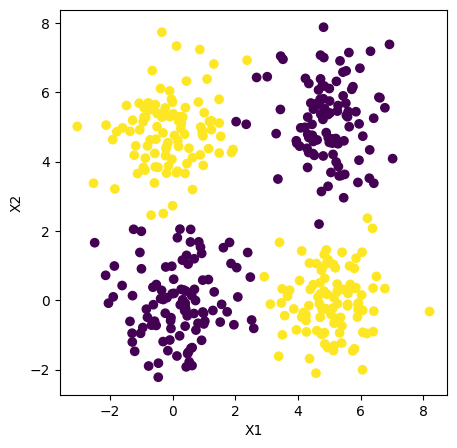

In [77]:
fig = plt.figure(figsize=(5, 5))
plt.scatter(X[:, 0], X[:, 1], c=pred)
plt.xlabel('X1')
plt.ylabel('X2')

# Make Some New X, S for Prediction Using Similar Scheme As Train Data

(Could have split data into test and train instead of doing this)

In [98]:
samples = 10
X1_test = np.concatenate((np.random.normal(0, 1, samples), np.random.normal(0, 1, samples)))
X2_test = np.concatenate((np.random.normal(0, 1, samples), np.random.normal(5, 1, samples)))
X_test = np.vstack((X1_test, X2_test)).T
S_test = np.concatenate((np.zeros(samples), np.zeros(samples)))

In [99]:
predictions = decision.predict(X_test)

Text(0, 0.5, 'X2')

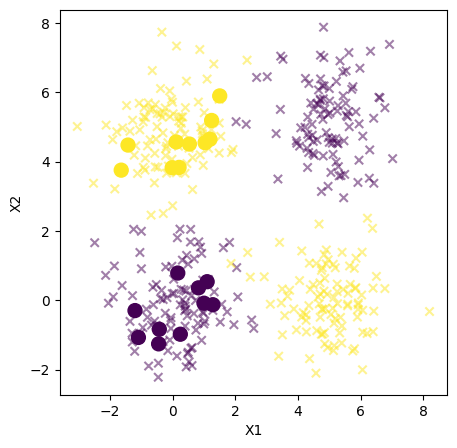

In [100]:
fig = plt.figure(figsize=(5, 5))
plt.scatter(X_test[:, 0], X_test[:, 1], c=predictions, marker='o', s=100)
plt.scatter(X[:, 0], X[:, 1], c=S, marker='x', alpha=0.5)
plt.xlabel('X1')
plt.ylabel('X2')

# PHEW!!!